# Lab:  Model selection for basketball data

In this lab, you will apply polynomial regression with model order selection to a basketball dataset. 

Before doing this lab, you should review the polynomial model selection demo.  In addition to the concepts in that demo, you will learn to:
* Fit a polynomial model for a given model order 
* Select the model order via K-fold cross-validation and the one-standard-error rule.
  

## Loading the data

We first load the standard packages.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

We now load the basketball dataset, which we can get from `openml`.

In [2]:
from sklearn.datasets import fetch_openml
basketball = fetch_openml(name="baskball", version=1)

D:\anaconda\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Let's turn this dataset into a `pandas` dataframe for ease of handling, and examine the features.

In [3]:
import pandas as pd
df = pd.DataFrame(basketball.data)
df.head()

,assists_per_minute,height,time_played,age
0,0.0888,201,36.02,28
1,0.1399,198,39.32,30
2,0.0747,198,38.80,26
3,0.0983,191,40.71,30
4,0.1276,196,38.40,28


In this lab, we will ignore `basketball.target` and instead investigate the relationship between age and time played.  For this purpose, create the feature vector `x` using the values in the `age` column using the `numpy.array` command.  Similarly, create the target vector `y` using the values in the `time_played` column.

In [6]:
x = np.array(df['age'])
y = np.array(df['time_played'])
x

array([28, 30, 26, 30, 28, 31, 30, 27, 29, 24, 27, 29, 24, 30, 28, 32, 25,
       29, 34, 23, 32, 28, 28, 23, 32, 27, 34, 26, 30, 30, 23, 31, 28, 27,
       25, 32, 29, 34, 28, 23, 26, 30, 32, 27, 27, 25, 24, 27, 25, 27, 31,
       30, 25, 26, 24, 26, 31, 24, 27, 28, 22, 30, 31, 23, 25, 31, 33, 28,
       37, 28, 24, 34, 24, 28, 33, 23, 26, 28, 26, 25, 26, 25, 27, 35, 31,
       25, 30, 24, 27, 27, 25, 24, 24, 23, 23, 32], dtype=int64)

# Fitting Models with Different Orders
We will now fit the polynomial model to the data using order d = 1 and order d = 5, for illustration.

For this, we'll use the `polyfit` command of the `numpy.polynomial.polynomial` library.

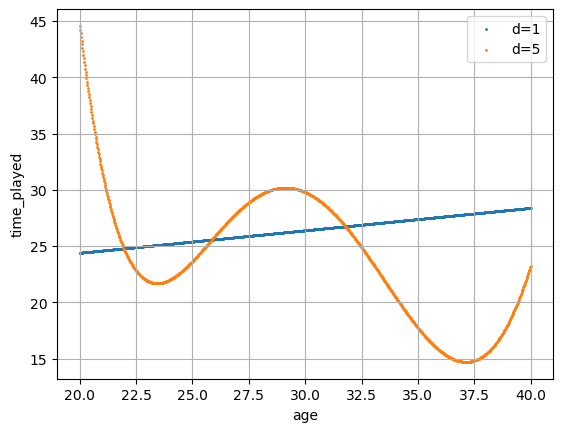

In [82]:
import numpy.polynomial.polynomial as poly
d1 = 1
d2 = 5
beta1 = poly.polyfit(x, y, d1)
beta2 = poly.polyfit(x, y, d2)
xp = np.linspace(20, 40, 1000)
yp_hat1 = poly.polyval(xp, beta1)
yp_hat2 = poly.polyval(xp, beta2)
plt.scatter(xp, yp_hat1, s = 1, label = 'd=1')
plt.scatter(xp, yp_hat2, s = 1, label = 'd=5')
plt.xlabel('age')
plt.ylabel('time_played')
plt.legend()
plt.grid()

How do these two model orders perform?  Are the results as expected? Can we do better?

## K-fold Cross-Validation

We now optimize the polynomial model order using 10-fold cross-validation (CV).  You can follow the method used in the polynomial demo.  The first step is to create a matrix of CV-nRSS values over all hypothesized model orders and all splits.  Consider model orders between 0 and 7.

In [77]:
from sklearn import model_selection

k = 10
kfo = model_selection.KFold(n_splits = k, shuffle = True)
dtest = np.arange(0, 8)
nd = len(dtest)
nRSScv = np.zeros((nd,k))
for itsplit, ind in enumerate(kfo.split(x)):
    itr, its = ind
    xtr = x[itr]
    ytr = y[itr]
    xts = x[its]
    yts = y[its]
    for it, d in enumerate(dtest):
        beta_hat = poly.polyfit(xtr, ytr, d)
        y_hat = poly.polyval(xts, beta_hat)
        nRSScv[it,itsplit] = np.mean((yts - y_hat)**2)
nRSScv

array([[ 85.88532861,  89.30787691,  70.7207924 ,  50.19824816,
         67.17836684,  92.21163854,  54.52121703,  68.27617811,
         78.92945874,  87.3017969 ],
       [ 88.36439953,  87.35734613,  74.51975743,  48.60027012,
         70.59995589,  93.73030862,  54.56128211,  66.45543363,
         83.42133882,  84.90405481],
       [ 64.7983147 ,  77.59166595,  54.15303121,  40.03694894,
         85.00579207,  68.24669897,  69.15971412,  67.40769031,
         72.06718309,  70.36415496],
       [ 81.07494062,  76.51660699,  53.02820668,  40.84084996,
         85.1573557 ,  73.11979664,  70.11410936,  66.4168432 ,
         72.95765799,  69.75154582],
       [ 60.15113422,  76.38972018,  52.09493728,  40.87567827,
         72.7544484 ,  67.29845113,  83.46573792,  69.29506954,
         73.93528507,  64.18598703],
       [ 58.61137596,  76.66296224,  53.69453366,  40.88448581,
         72.40099382,  67.67349821,  83.49530977,  69.831915  ,
         73.8002922 ,  64.91085061],
       [62

Next, compute the mean and standard error of the nRSS over the folds for each model order.  The standard error is defined as the standard deviation divided by $\sqrt{K}$, where $K$ is the number of folds.  Use `ddof=1` in `np.std` to get the unbiased version.

With these nRSS statistics, use the one-standard-error rule to find the best model order.  Print out the model order that minimizes mean CV-nRSS, as well as the model order estimated by the one-standard-error rule, using the format

    The model order that minimizes mean CV-nRSS is xx
    The model order estimated by the one-standard-error rule is xx

In [78]:
mean = np.mean(nRSScv, axis = 1)
SE = np.std(nRSScv, axis = 1, ddof = 1) / np.sqrt(k)
nRSSmin = np.min(mean)
dmin = np.where(mean == nRSSmin)[0][0]
nRSStgt = mean[dmin] + SE[dmin]
d_ose = np.where(mean <= nRSStgt)[0][0]
print('The model order that minimizes mean CV-nRSS is', dmin)
print('The model order estimated by the one-standard-error rule is ', d_ose)

The model order that minimizes mean CV-nRSS is 4
The model order estimated by the one-standard-error rule is  2


Next, illustrate the one-standard-error-rule procedure by making a plot that shows the following:
* the mean CV-nRSS curve with errorbars
* a dashed line showing the model order yielding minimum mean CV-nRSS
* a dashed line showing the target nRSS
* a dashed line showing the model order estimated by the one-standard-error rule

Also, add a grid and axis labels to your plot.  Use `plt.ylim` if needed to zoom into the relevant range.

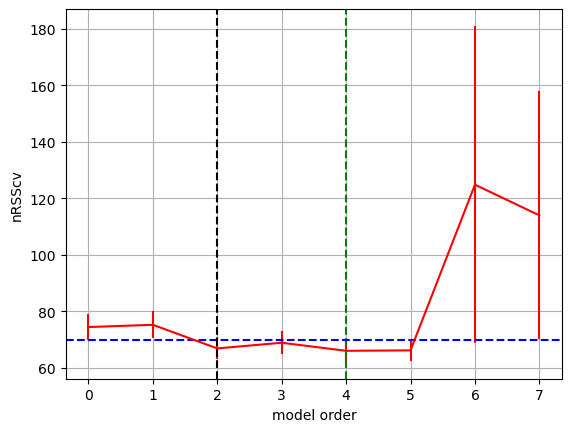

In [79]:
plt.errorbar(dtest, mean, c='r', yerr = SE)
plt.axvline(dmin, c = 'g', ls = '--')
plt.axhline(nRSStgt, c = 'b', ls = '--')
plt.axvline(d_ose, c = 'k', ls = '--')
plt.xlabel('model order')
plt.ylabel('nRSScv')
plt.grid()

Finally, make a scatter plot of the data and superimpose
* the polynomial prediction curve with the order that minimizes mean CV-nRSS
* the polynomial prediction curve with the order selected by the one-standard-error rule

As usual, add grid lines, axis labels, and a legend to your plot.

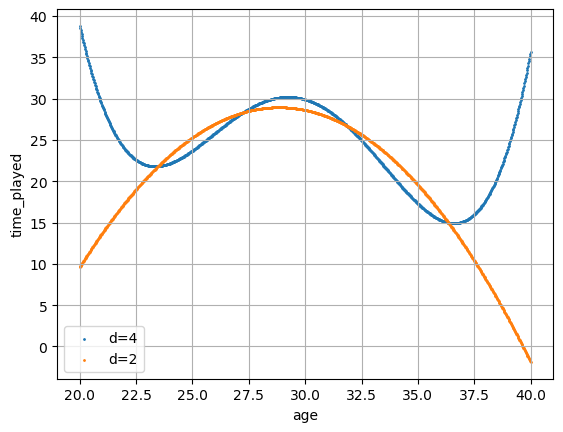

In [84]:
_d1 = dmin
_d2 = d_ose
_beta1 = poly.polyfit(x, y, _d1)
_beta2 = poly.polyfit(x, y, _d2)
_xp = np.linspace(20, 40, 1000)
_yp_hat1 = poly.polyval(_xp, _beta1)
_yp_hat2 = poly.polyval(_xp, _beta2)
plt.scatter(_xp, _yp_hat1, s = 1, label = 'd=4')
plt.scatter(_xp, _yp_hat2, s = 1, label = 'd=2')
plt.xlabel('age')
plt.ylabel('time_played')
plt.legend()
plt.grid()

Note that because the shuffling done by the K-fold object is random, the results may vary a bit every time you run the code.  If that is distracting, you can fix the `random_seed` of the K-fold object.